In [1]:
from notebook_util import *
%matplotlib inline

In [2]:
from minee.data.mix_gaussian import MixedGaussian

It is better to use `sample_size` instead of `n_sample`

In [13]:
np.random.seed(0)
sample_size = 200
rho1 = 0.9
data = MixedGaussian(n_samples=sample_size,rho1=rho1).data
data_t = torch.FloatTensor(data).to(device)

Separate X data and Y data for the estimation. This should be a preprocessing done before instead of after feeding the data to the model.

In [48]:
X = data[:,[0]]
Y = data[:,[1]]

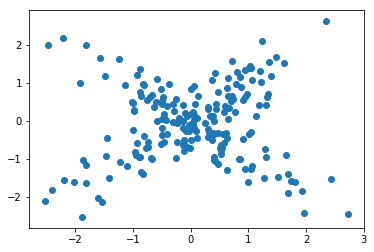

In [49]:
plt.scatter(X,Y)

Generate the reference samples by resampling.

In [50]:
X_ref = resample(X,batch_size=sample_size)
Y_ref = resample(Y,batch_size=sample_size)

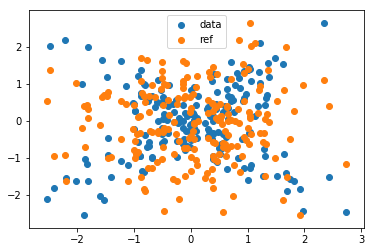

In [51]:
plt.scatter(X,Y,label="data")
plt.scatter(X_ref,Y_ref,label="ref")
plt.legend()

In [56]:
class Net(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        sigma = .02
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=sigma)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [54]:
XY_t = torch.FloatTensor(np.concatenate((X,Y),axis=1)).to(device)

In [55]:
XY_ref_t = torch.FloatTensor(np.concatenate((X_ref,Y_ref),axis=1)).to(device)

In [113]:
batch_size = int(sample_size*1)
net_list = []
mi_lb_list = []
batch_mi_lb_list = []
batch_loss_list = []
ma_rate = 0.1
ma_ef = 1
lr = 1e-3
XY_net = Net(input_size=X.shape[1]+Y.shape[1]).to(device)
optimizer = optim.Adam(XY_net.parameters(),lr=lr)

Automatically load previous results from db file if exists

In [93]:
fname = 'mix_gaussian.db'
if os.path.exists(fname):
    with open(fname,'rb') as f:
        net_list,mi_lb_list,batch_loss_list,batch_mi_lb_list,ma_et = dill.load(f)
        mine_net.load_state_dict(net[-1])
        print('results loaded from '+fname)

Repeately run the following to continue to train

In [120]:
for i in range(1000):
    optimizer.zero_grad()
    batch_XY = resample(XY_t,batch_size=batch_size)
    #batch_XY_ref = resample(XY_ref_t,batch_size=batch_size)
    batch_XY_ref = torch.FloatTensor(np.concatenate((resample(X,batch_size=batch_size),resample(Y,batch_size=batch_size)),axis=1)).to(device)
    fXY = XY_net(batch_XY)
    efXY_ref = torch.exp(XY_net(batch_XY_ref))
    batch_mi_lb = torch.mean(fXY) - torch.log(torch.mean(efXY_ref))
    #loss = -batch_mi_lb
    ma_ef = (1-ma_rate)*ma_ef + ma_rate*torch.mean(efXY)
    batch_loss = -(torch.mean(fXY) - (1/ma_ef.mean()).detach()*torch.mean(efXY_ref))
    batch_loss.backward()
    optimizer.step()    
    mi_lb_list = np.append(mi_lb_list, \
                            (torch.mean(XY_net(XY_t)) \
                             - torch.log(torch.mean(torch.exp(XY_net(XY_ref_t))))).cpu().item())
    batch_mi_lb_list = np.append(batch_mi_lb_list,batch_mi_lb.cpu().item())
    batch_loss_list = np.append(batch_loss_list,batch_loss.cpu().item())
net_list = np.append(net_list,XY_net.state_dict())

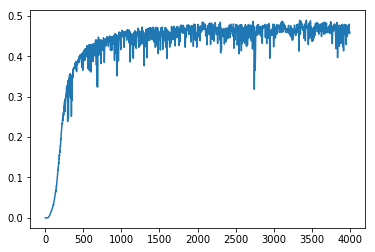

In [121]:
plt.plot(mi_lb_list)

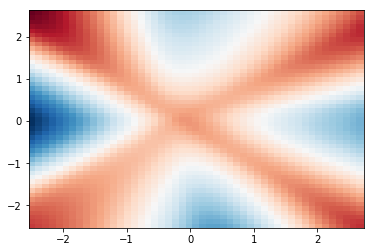

In [124]:
getHeatMap(XY_net,XY_t.cpu(),grids=[50,50])

To save new results to a db file using the following code, delete the existing db file.

In [126]:
if not os.path.exists(fname):
    with open(fname,'wb') as f:
        dill.dump([net_list,mi_lb_list,batch_loss_list,batch_mi_lb_list,ma_et],f)
        print('results saved to '+fname)